In [83]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.optimizers import SGD
from sklearn.cluster import KMeans
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cdist
import seaborn as sns; sns.set()
%matplotlib inline

Hàm để đọc dữ liệu tất cả ảnh có trong đường dẫn được truyền vào, đầu ra gồm ma trận mxn (m ảnh, n features) và mảng chứa class tương ứng với từng ảnh:

In [84]:
ROWS = 150
COLUMNS = 150
CHANNELS = 3
# CHANNELS = 1


# Function to read image and convert to the specified size
def read_image(file_path):
    # return cv2.resize(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE), (ROWS, COLUMNS), cv2.INTER_AREA).flatten()
    return cv2.resize(cv2.imread(file_path, cv2.IMREAD_COLOR), (ROWS, COLUMNS), cv2.INTER_AREA).flatten()


def get_image_path(path):
    images = []
    categories = []

    # Get the list of class folders
    class_folders = os.listdir(path)

    # Iterate over each class folder
    for class_folder in class_folders:
        # Get the path to the current class folder
        class_folder_path = os.path.join(path, class_folder)

        # Get the list of image files in the class folder
        image_files = os.listdir(class_folder_path)

        # Iterate over each image file
        for image_file in image_files:
            # Get the path to the current image file
            image_file_path = os.path.join(class_folder_path, image_file)
            images.append(image_file_path)
            categories.append(class_folder)

    return images, categories


def get_data(path):
    images, categories = get_image_path(path)

    X = np.zeros((len(images), ROWS * COLUMNS * CHANNELS))

    for i, image_path in enumerate(tqdm(images)):
        X[i, :] = read_image(image_path)

    return X, np.array(categories)

Đọc dữ liệu training và validation:

In [85]:
X_train, y_train = get_data('datav2/train/')
X_valid, y_valid = get_data('datav2/validation/')
X_test, y_test = get_data('datav2/test/')

100%|██████████| 996/996 [00:03<00:00, 291.77it/s]


In [86]:
X_train.shape

(5000, 67500)

In [87]:
X_valid.shape

(2500, 67500)

In [88]:
X_test.shape

(996, 67500)

<p>2.  Sử dụng ít nhất 02 thuật toán phân cụm dữ liệu để phân cụm dữ liệu, sau đó hiển thị trực quan dữ liệu với đánh dấu các cụm.</p>

Chuẩn hóa dữ liệu bằng cách thay đổi các giá trị điểm ảnh (khoảng 0-255) về khoảng 0-1

In [89]:
# Standardizing the dataset
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

In [90]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)
y_test_encoded = le.transform(y_test)

In [91]:
pca2d = PCA(n_components=2)
X_train_pca2d = pca2d.fit_transform(X_train)

# Print the amount of lost information
print("Lượng thông tin mất mát khi giảm chiều: {:.2f}%".format((1 - sum(pca2d.explained_variance_ratio_)) * 100))

Lượng thông tin mất mát khi giảm chiều: 58.08%


Sử dụng KMeans để phân cụm dữ liệu

In [92]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_pca2d)

KMeans(n_clusters=5, random_state=42)

In [93]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [94]:
def plot_kmeans(X, labels, centers, rseed=0, ax = None):
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=3, cmap='viridis', zorder=2)
    ax.scatter(centers[:,0], centers[:, 1], marker = "x", c = 'k', zorder=3)

    # plot the representation of the KMeans model
    radii = [cdist(X[labels == i], [center]).max()
            for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=2, alpha=0.5, zorder=1, edgecolor='k'))

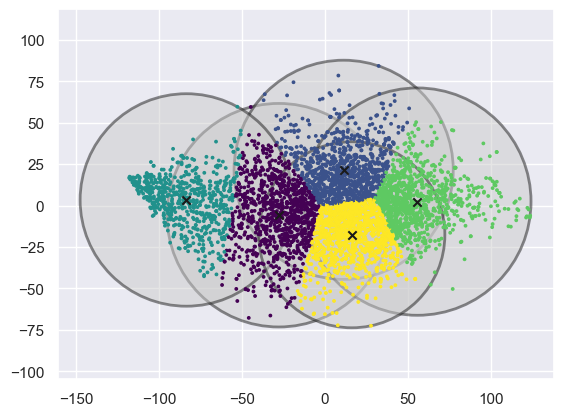

In [95]:
plot_kmeans(X_train_pca2d, labels, centroids)

Sử dụng GMM để phân cụm dữ liệu

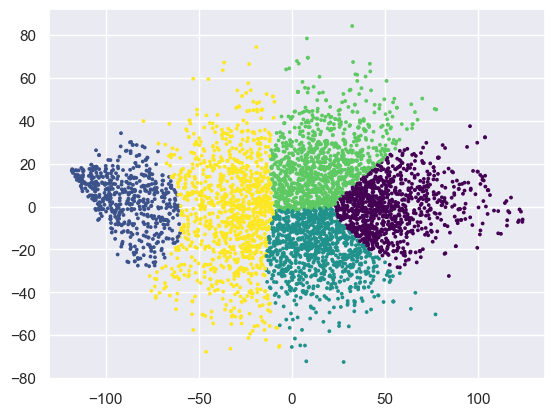

In [96]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5).fit(X_train_pca2d)
labels = gmm.predict(X_train_pca2d)
plt.scatter(X_train_pca2d[:, 0], X_train_pca2d[:, 1], c=labels, s=3, cmap='viridis')

In [107]:
probs = gmm.predict_proba(X_train_pca2d)
print(probs.round(3))

[[0.    0.759 0.001 0.001 0.239]
 [0.08  0.    0.263 0.352 0.305]
 [0.031 0.    0.049 0.879 0.041]
 ...
 [0.63  0.    0.358 0.012 0.   ]
 [0.482 0.    0.222 0.293 0.003]
 [0.428 0.    0.224 0.343 0.005]]


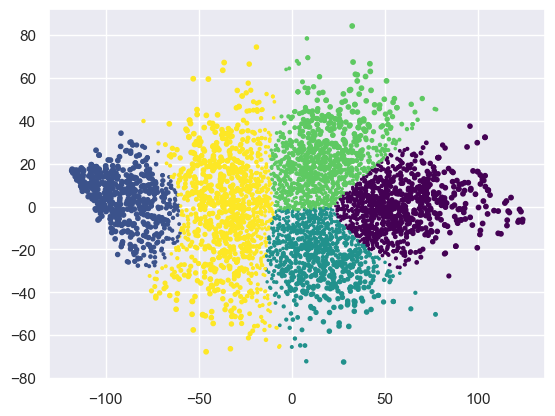

In [111]:
size = 10 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X_train_pca2d[:, 0], X_train_pca2d[:, 1], c=labels, cmap='viridis', s=size)

In [123]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

    ax.scatter(position[0], position[1], marker='x', c = 'k', zorder = 5)
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=3, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, edgecolor='k')

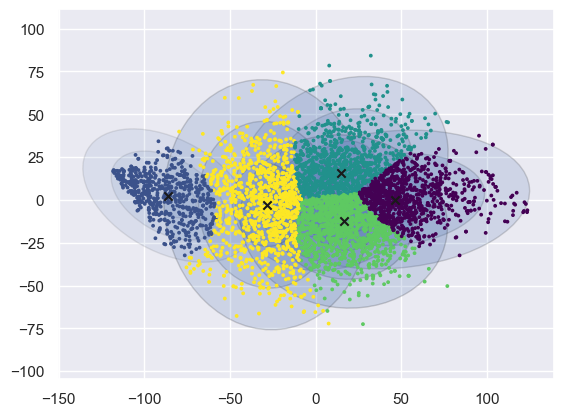

In [124]:
plot_gmm(gmm, X_train_pca2d)